In [100]:
import importlib
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import lstm_predictor
importlib.reload(lstm_predictor)
from lstm_predictor import LSTMPredictor

import preprocessing
importlib.reload(preprocessing)
from preprocessing import Preprocessing

import data_collection
importlib.reload(data_collection)
from data_collection import DataCollection

import data_plotter
importlib.reload(data_plotter)
from data_plotter import DataPlotter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### DATA COLLECTION #####

In [101]:
# Define parameters for data collection
tickers = ["GOOGL"]
start_date = "2000-01-01"
end_date = datetime.today().date()
data_path = "../data"

# Initialize DataCollection and fetch data
data_collector = DataCollection(tickers, start_date, end_date, folder_path=data_path)
data_collector.fetch_and_save_all()

[*********************100%***********************]  1 of 1 completed

Data saved to ../data\GOOGL_data.csv


##### DATA PREPARATION #####

In [102]:
# Parameters for preprocessing
sequence_length = 100
split_ratio = 0.8
batch_size = 32

# Preprocessing
pp = Preprocessing(folder_path=data_path, split_ratio=split_ratio, sequence_length=sequence_length)
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_train_dates, x_test_dates, y_train_dates, y_test_dates = pp.preprocess_pipeline()

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### MODEL SETUP #####

In [103]:
# Define model hyperparameters
input_size = 5  # Number of input features (['Open', 'High', 'Low', 'Close', 'Volume'])
output_size = 1  # Predicting values 'Close' for the next day
hidden_size = 50  # Number of hidden units in LSTM
learning_rate = 0.001 # Learning rate for optimizer
num_layers = 2 # Number of LSTM layers. Has to be > 1, because of the dropout.
dropout = 0.2 # Dropout rate for regularization

# Instantiate the model and move to the appropriate device
model = LSTMPredictor(input_sz=input_size, hidden_sz=hidden_size, num_layers=num_layers,dropout=dropout, output_sz=output_size).to(device)

# Define loss function and optimize
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##### TRAINING THE MODEL #####

In [104]:
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    running_loss = 0

    for x, y in train_loader:
        optimizer.zero_grad()
        outputs = model.forward(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.6f}")

Epoch 1/50, Loss: 0.021052
Epoch 2/50, Loss: 0.001191
Epoch 3/50, Loss: 0.001146
Epoch 4/50, Loss: 0.000968
Epoch 5/50, Loss: 0.000737
Epoch 6/50, Loss: 0.000583
Epoch 7/50, Loss: 0.000525
Epoch 8/50, Loss: 0.000579
Epoch 9/50, Loss: 0.000530
Epoch 10/50, Loss: 0.000549
Epoch 11/50, Loss: 0.000433
Epoch 12/50, Loss: 0.000432
Epoch 13/50, Loss: 0.000454
Epoch 14/50, Loss: 0.000378
Epoch 15/50, Loss: 0.000412
Epoch 16/50, Loss: 0.000425
Epoch 17/50, Loss: 0.000299
Epoch 18/50, Loss: 0.000293
Epoch 19/50, Loss: 0.000383
Epoch 20/50, Loss: 0.000241
Epoch 21/50, Loss: 0.000259
Epoch 22/50, Loss: 0.000313
Epoch 23/50, Loss: 0.000257
Epoch 24/50, Loss: 0.000264
Epoch 25/50, Loss: 0.000224
Epoch 26/50, Loss: 0.000243
Epoch 27/50, Loss: 0.000196
Epoch 28/50, Loss: 0.000222
Epoch 29/50, Loss: 0.000240
Epoch 30/50, Loss: 0.000196
Epoch 31/50, Loss: 0.000199
Epoch 32/50, Loss: 0.000202
Epoch 33/50, Loss: 0.000178
Epoch 34/50, Loss: 0.000246
Epoch 35/50, Loss: 0.000189
Epoch 36/50, Loss: 0.000159
E

##### EVALUATING THE MODEL #####

Test Loss: 0.31830

Close: MSE = 9.95928, Variance = 0.10110
  -> The model does not outperform a mean-based prediction for Close.
--------------------------------------------------
Date: 2021-04-05
Sample prediction (original scale): 1.01
Actual values (original scale): 1.27
--------------------------------------------------
Date: 2021-04-06
Sample prediction (original scale): 1.01
Actual values (original scale): 1.26
--------------------------------------------------
Date: 2021-04-07
Sample prediction (original scale): 1.01
Actual values (original scale): 1.28
--------------------------------------------------
Date: 2021-04-08
Sample prediction (original scale): 1.02
Actual values (original scale): 1.28
--------------------------------------------------
Date: 2021-04-09
Sample prediction (original scale): 1.02
Actual values (original scale): 1.30
--------------------------------------------------


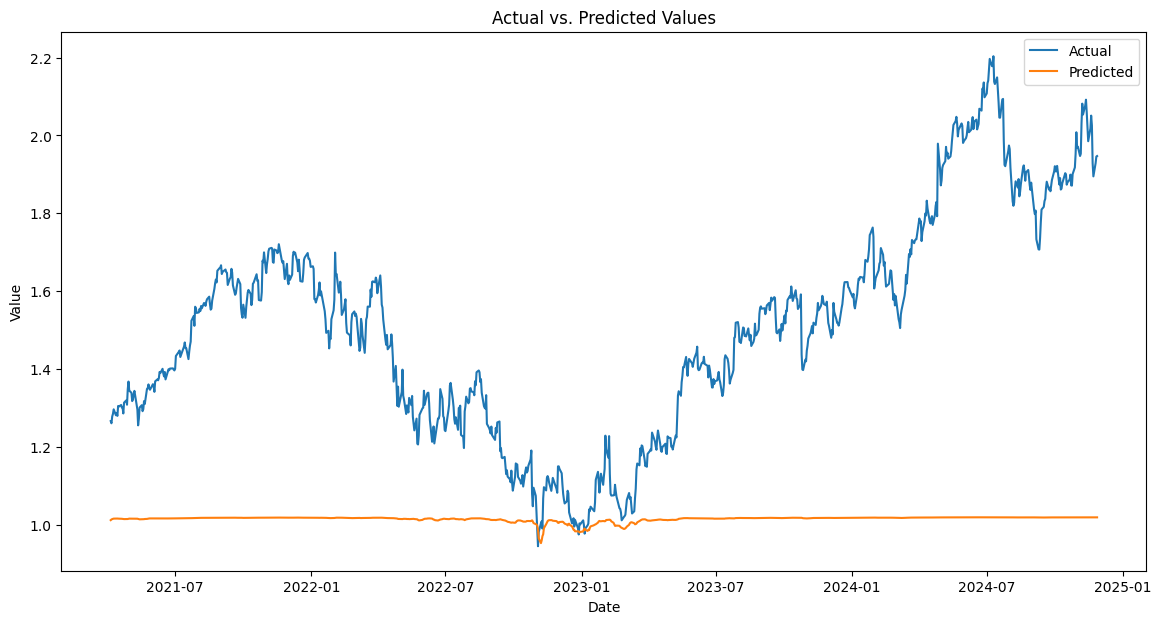

Variance of all samples: 0.07771
The model does not perform better than a mean-based prediction.


In [106]:
model.eval()
test_loss = 0.0
predictions = []
actuals = []
mse = 0.0
variance = 0.0

model.eval()
# Disable gradient computation for evaluation
with torch.no_grad():
    for x, y in test_loader:
        output = model.forward(x)
        loss = criterion(output, y)
        test_loss += loss.item()
        predictions.append(output.cpu())
        actuals.append(y.cpu())
        mse += nn.functional.mse_loss(output, y, reduction='sum').item() # Compute MSE for the single output (Close price)
        variance += torch.sum((y - torch.mean(y))**2).item() # Compute Variance for the single output (Close price)

# Calculate average test loss
test_loss /= len(test_loader) 
print(f"Test Loss: {test_loss:.5f}")

# Calculate average MSE and Variance
num_samples = len(test_loader)  # Total number of samples
mse_avg = mse / num_samples
variance_avg = variance / num_samples

# Post-processing predictions and actuals for inverse scaling
predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

# Print MSE and Variance comparison
feature_name = "Close"
print(f"\n{feature_name}: MSE = {mse_avg:.5f}, Variance = {variance_avg:.5f}")
if mse_avg < variance_avg:
    print(f"  -> The model performs better than a mean-based prediction for {feature_name}.")
else:
    print(f"  -> The model does not outperform a mean-based prediction for {feature_name}.")
print("-" * 50)

# Print sample predictions and actual values
for i in range(5):
    print(f"Date: {y_test_dates[i]}")
    prediction_str = ", ".join([f"{x:.2f}" for x in predictions[i]])
    actual_str = ", ".join([f"{x:.2f}" for x in actuals[i]])
    print(f"Sample prediction (original scale): {prediction_str}")
    print(f"Actual values (original scale): {actual_str}")
    print("-" * 50)

# Plotting results
plotter = DataPlotter()
df_results = plotter.create_results_dataframe(y_test_dates, actuals, predictions)
plotter.plot_results(df_results)

# Print overall variance
variance_all_samples = np.var(actuals)
print(f"Variance of all samples: {variance_all_samples:.5f}")

# Final comparison
if test_loss < variance_all_samples:
    print("The model performs better than a mean-based prediction.")
else:
    print("The model does not perform better than a mean-based prediction.")